<a href="https://colab.research.google.com/github/SofiAVBM/student-course-load-analysis/blob/main/BD_Estudiantes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Este proyecto realiza un análisis exploratorio de datos sobre la carga académica de estudiantes y los patrones de co-inscripción entre materias de una base de datos de inscripciones.


In [ ]:
##Limpieza de datos
import pandas as pd
import numpy as np

CSV_PATH = "decrypted.csv"

# 1) Lectura (Revizar posibles errores de lectura)
def robust_read_csv(path):
    try:
        return pd.read_csv(path, sep=None, engine="python")
    except Exception:
        # fallback con encoding utf-8 y latin1
        for enc in ("utf-8", "latin1"):
            try:
                return pd.read_csv(path, encoding=enc)
            except Exception:
                pass
    raise ValueError("No se pudo leer el CSV. Revisa la ruta o el formato.")

df = robust_read_csv(CSV_PATH)


# 2) Normalizar nombres de columna (minúsculas, sin espacios extras)
df.columns = [str(c).strip().lower().replace(" ", "_").replace("/", "_") for c in df.columns]

print("Resumen antes de la limpieza:")
print("Columnas detectadas:", df.columns.tolist())
print("Primeras filas antes de limpieza:\n", df.head())
print("Filas totales:", len(df))
print("Materias únicas:", df['Materia/examen'].nunique() if 'Materia/examen' in df.columns else df['materia_examen'].nunique())
print("Secciones únicas (raw):", df['Secc'].nunique() if 'Secc' in df.columns else df['secc'].nunique())
print("Estudiantes únicos (por código):", df['codigo'].nunique())
print("-" * 50)

# 3) Quitar filas  vacías
df = df.dropna(how="all").copy()

# 4) Eliminar columnas irrelevantes

expected_cols = ["materia/examen", "secc", "codigo"]
candidates = {c.lower(): c for c in df.columns}
# intenta mapear
mapped = {}
for col in expected_cols:
    if col in df.columns:
        mapped[col] = col
    else:
        # buscar columna que contenga partes
        for existing in df.columns:
            if col.replace("/", "_") in existing or col.split("/")[0] in existing:
                mapped[col] = existing
                break

if len(mapped) == len(expected_cols):
    df = df[[mapped[c] for c in expected_cols]].rename(columns={
        mapped["materia/examen"]: "materia_examen",
        mapped["secc"]: "secc",
        mapped["codigo"]: "codigo"
    })
else:
    # renombrar
    df = df.rename(columns={
        next((c for c in df.columns if "mater" in c), "materia_examen"): "materia_examen",
        next((c for c in df.columns if "secc" in c or "sección" in c), "secc"): "secc",
        next((c for c in df.columns if "cod" in c), "codigo"): "codigo"
    })
    # Revizar que no hallan más columnas
    print("Advertencia: No se encontraron las 3 columnas exactas. Columnas actuales:", df.columns.tolist())

# 5) Limpiar espacios y normalizar texto
df["materia_examen"] = df["materia_examen"].astype(str).str.strip()
df["secc"] = df["secc"].astype(str).str.strip()
df["codigo"] = df["codigo"].astype(str).str.strip()

# 6) Encontrar Duplicados
dups = df.duplicated(subset=["materia_examen", "secc", "codigo"])
print(f"Duplicados exactos encontrados: {dups.sum()}")
df = df[~dups].copy()

# 7) Valores faltantes
print("Valores faltantes por columna:\n", df.isnull().sum())
if df["codigo"].isnull().any() or (df["codigo"] == "").any():
    print("Hay códigos vacíos o nulos. Filtrando filas sin código")
    df = df[df["codigo"].notnull() & (df["codigo"].str.len() > 0)].copy()

# 8) Forzar tipos de datos
def safe_int_convert(s):
    try:
        return int(float(s))
    except Exception:
        return np.nan

df["secc_int"] = df["secc"].apply(safe_int_convert)
print("Filas con sección no convertibles a entero:", df["secc_int"].isnull().sum())

# Normalizar código de estudiante: eliminar puntos, guiones, espacios y dejar como string
df["codigo"] = df["codigo"].str.replace(r"[^\dA-Za-z]", "", regex=True)

# 9) Separar 'materia_examen' en prefijo + codigo
mat_split = df["materia_examen"].str.split("-", n=1, expand=True)
df["materia_prefijo"] = mat_split[0].str.strip()
df["materia_numero"] = mat_split[1].str.strip() if mat_split.shape[1] > 1 else None

# Si no hay guion separarlos con regex
mask_no_num = df["materia_numero"].isnull() | df["materia_numero"].isna()
if mask_no_num.any():
    import re
    def split_letters_numbers(s):
        m = re.match(r"^([A-Za-z]+)([\d\-]+.*)$", s)
        if m:
            return pd.Series([m.group(1), m.group(2)])
        return pd.Series([s, np.nan])
    df.loc[mask_no_num, ["materia_prefijo", "materia_numero"]] = df.loc[mask_no_num, "materia_examen"].apply(split_letters_numbers)

# 10) Revisar códigos duplicados por misma materia (posible doble inscripción)
same_student_multiple = df.duplicated(subset=["materia_examen", "codigo"], keep=False)
print("Casos donde el mismo código aparece más de una vez en la misma materia (posible doble inscripción):",
      df[same_student_multiple].shape[0])

# 11) Reporte de limpeza
print("\nResumen post-limpieza:")
print("Filas totales:", len(df))
print("Materias únicas:", df["materia_examen"].nunique())
print("Secciones únicas (raw):", df["secc"].nunique())
print("Estudiantes únicos (por código):", df["codigo"].nunique())

# 12) Guardar CSV limpio para análisis posteriores
CLEAN_PATH = "decrypted_clean.csv"
df.to_csv(CLEAN_PATH, index=False)
print(f"CSV limpio guardado en: {CLEAN_PATH}")

df.head(10)


Resumen antes de la limpieza:
Columnas detectadas: ['materia_examen', 'secc', 'codigo']
Primeras filas antes de limpieza:
   materia_examen secc     codigo
0      AFIN-5005    1  200620377
1      AFIN-5005    1  201126201
2      AFIN-5005    1  201414825
3      AFIN-5005    1  201421834
4      AFIN-5005    1  201424798
Filas totales: 129600
Materias únicas: 3239
Secciones únicas (raw): 138
Estudiantes únicos (por código): 20350
--------------------------------------------------
Duplicados exactos encontrados: 1
Valores faltantes por columna:
 materia_examen    0
secc              0
codigo            0
dtype: int64
Filas con sección no convertibles a entero: 24995
Casos donde el mismo código aparece más de una vez en la misma materia (posible doble inscripción): 142

Resumen post-limpieza:
Filas totales: 129599
Materias únicas: 3239
Secciones únicas (raw): 139
Estudiantes únicos (por código): 20350
CSV limpio guardado en: decrypted_clean.csv


,materia_examen,secc,codigo,secc_int,materia_prefijo,materia_numero
0,AFIN-5005,1,200620377,1.0,AFIN,5005
1,AFIN-5005,1,201126201,1.0,AFIN,5005
2,AFIN-5005,1,201414825,1.0,AFIN,5005
3,AFIN-5005,1,201421834,1.0,AFIN,5005
4,AFIN-5005,1,201424798,1.0,AFIN,5005
5,AFIN-5005,1,201520161,1.0,AFIN,5005
6,AFIN-5005,1,201521994,1.0,AFIN,5005
7,AFIN-5005,1,201533613,1.0,AFIN,5005
8,AFIN-5005,1,201613594,1.0,AFIN,5005
9,AFIN-5005,1,201616331,1.0,AFIN,5005


#Conteos básicos y distribución de carga.

1. Confirma la integridad del dataset (totales y únicos).
2. Cuenta cuántos estudiantes distintos hay por materia y por sección.
3. Genera histogramas para secciones y carga académica
4. Agrupa por prefijo de materia
5. Calcula estadísticas: media, mediana, desviación estándar de materias por estudiante.
6. Guarda CSVs auxiliares

=== RESUMEN GENERAL ===
Filas totales: 129599
Materias únicas: 3239
Secciones únicas: 138
Estudiantes únicos: 20350

Top 10 materias por número de inscritos:
materia_examen
ESCR-1102    1766
ESCR-1101    1753
CBCC-1177    1666
DERE-1300    1414
MATE-1201    1238
ISIS-1221    1026
MATE-1203     930
GEOC-1002     783
MATE-1214     743
MATE-1105     739
Name: codigo, dtype: int64

Top 10 secciones con más inscritos:
     materia_examen secc  num_inscritos
1577      DERE-3905    1            211
3430      INTL-2201    1            206
1407      DERE-1901    1            202
149       ADMI-3122    A            164
1564      DERE-3802    1            153
1563      DERE-3801    1            150
3287      IIND-3001    1            127
4117      MAIA-4110    1            127
4116      MAIA-4100    1            125
5207      MIID-4303    1            120


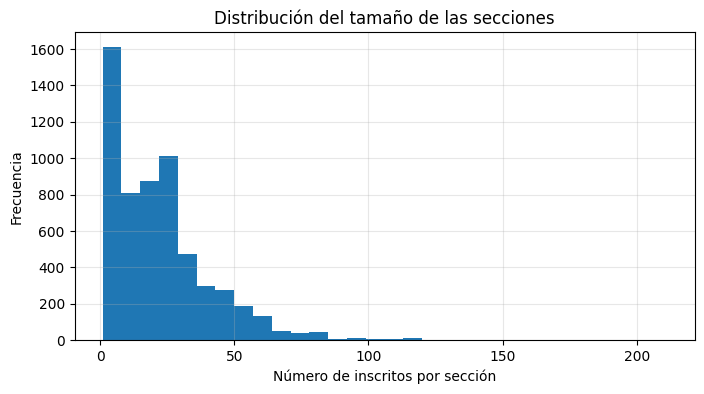


Materias con menos de 10 inscritos: 1143

Top 10 áreas (prefijos) con más estudiantes:
materia_prefijo
MATE    5300
LENG    3894
CBCA    3410
DERE    3027
ADMI    2626
DEPO    2577
ISIS    2527
ESCR    2191
CBPC    2141
ECON    2096
Name: codigo, dtype: int64


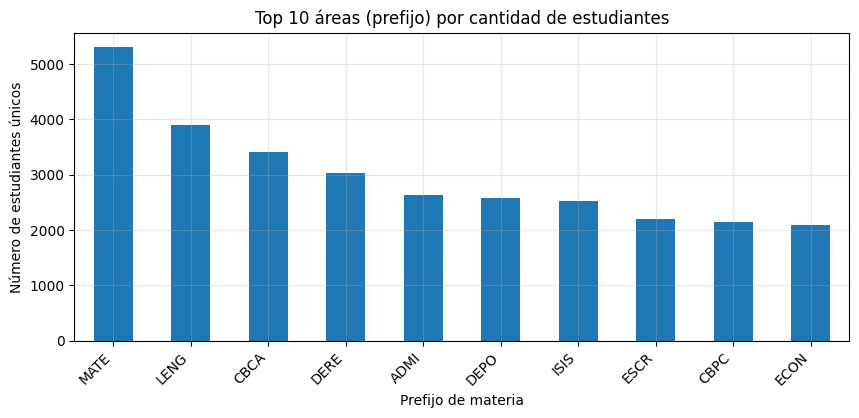


Estadísticas de carga académica (materias por estudiante):
count    20350.000000
mean         6.364619
std          3.495654
min          1.000000
25%          3.000000
50%          7.000000
75%          9.000000
max         20.000000
Name: materia_examen, dtype: float64


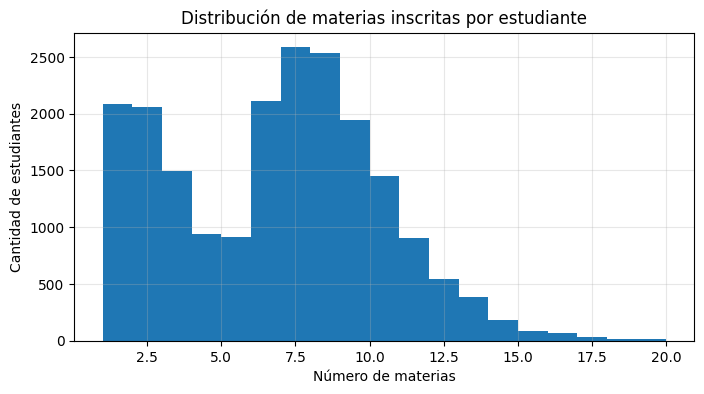


=== MÉTRICAS BASE PARA INFORME ===
Total filas: 129599
Materias únicas: 3239
Secciones únicas: 138
Estudiantes únicos: 20350
Promedio materias por estudiante: 6.364619164619165
Desviación estándar materias por estudiante: 3.495653639621853
Mediana materias por estudiante: 7.0
Materia más inscrita: ESCR-1102
Inscritos materia top: 1766


In [ ]:

import pandas as pd
import matplotlib.pyplot as plt

# Cargar el CSV limpio
CLEAN_PATH = "decrypted_clean.csv"
df = pd.read_csv(CLEAN_PATH)

print("=== RESUMEN GENERAL ===")
print("Filas totales:", len(df))
print("Materias únicas:", df["materia_examen"].nunique())
print("Secciones únicas:", df["secc"].nunique())
print("Estudiantes únicos:", df["codigo"].nunique())

# -------------------------------------------------
# 1) Inscritos por materia (todas las secciones combinadas)
inscritos_por_materia = df.groupby("materia_examen")["codigo"].nunique().sort_values(ascending=False)
print("\nTop 10 materias por número de inscritos:")
print(inscritos_por_materia.head(10))

# -------------------------------------------------
# 2) Inscritos por sección específica (materia + sección)
inscritos_por_seccion = df.groupby(["materia_examen", "secc"])["codigo"].nunique().reset_index()
inscritos_por_seccion.rename(columns={"codigo": "num_inscritos"}, inplace=True)
print("\nTop 10 secciones con más inscritos:")
print(inscritos_por_seccion.sort_values("num_inscritos", ascending=False).head(10))

# -------------------------------------------------
# 3) Distribución del tamaño de sección
plt.figure(figsize=(8,4))
plt.hist(inscritos_por_seccion["num_inscritos"], bins=30)
plt.title("Distribución del tamaño de las secciones")
plt.xlabel("Número de inscritos por sección")
plt.ylabel("Frecuencia")
plt.grid(True, alpha=0.3)
plt.show()

# -------------------------------------------------
# 4) Materias con menos de X inscritos (identificar riesgo o baja demanda)
umbral = 10
pocas_inscripciones = inscritos_por_materia[inscritos_por_materia < umbral]
print(f"\nMaterias con menos de {umbral} inscritos: {len(pocas_inscripciones)}")

# -------------------------------------------------
# 5) Materias agrupadas por departamento
if "materia_prefijo" in df.columns:
    inscritos_por_area = df.groupby("materia_prefijo")["codigo"].nunique().sort_values(ascending=False)
    print("\nTop 10 áreas (prefijos) con más estudiantes:")
    print(inscritos_por_area.head(10))

    plt.figure(figsize=(10,4))
    inscritos_por_area.head(10).plot(kind="bar")
    plt.title("Top 10 áreas (prefijo) por cantidad de estudiantes")
    plt.xlabel("Prefijo de materia")
    plt.ylabel("Número de estudiantes únicos")
    plt.xticks(rotation=45, ha="right")
    plt.grid(True, alpha=0.3)
    plt.show()

# -------------------------------------------------
# 6) Carga académica por estudiante (cuántas materias inscribió cada uno)
carga_estudiante = df.groupby("codigo")["materia_examen"].nunique()
print("\nEstadísticas de carga académica (materias por estudiante):")
print(carga_estudiante.describe())

plt.figure(figsize=(8,4))
plt.hist(carga_estudiante, bins=range(1, carga_estudiante.max()+1))
plt.title("Distribución de materias inscritas por estudiante")
plt.xlabel("Número de materias")
plt.ylabel("Cantidad de estudiantes")
plt.grid(True, alpha=0.3)
plt.show()

# -------------------------------------------------
# 7) Guardar métricas base para el informe
resumen = {
    "Total filas": len(df),
    "Materias únicas": df["materia_examen"].nunique(),
    "Secciones únicas": df["secc"].nunique(),
    "Estudiantes únicos": df["codigo"].nunique(),
    "Promedio materias por estudiante": carga_estudiante.mean(),
    "Desviación estándar materias por estudiante": carga_estudiante.std(),
    "Mediana materias por estudiante": carga_estudiante.median(),
    "Materia más inscrita": inscritos_por_materia.index[0],
    "Inscritos materia top": inscritos_por_materia.iloc[0]
}
print("\n=== MÉTRICAS BASE PARA INFORME ===")
for k, v in resumen.items():
    print(f"{k}: {v}")

# guardar resultados en CSV
#inscritos_por_materia.to_csv("/content/drive/MyDrive/Codelab/inscritos_por_materia.csv")
#inscritos_por_seccion.to_csv("/content/drive/MyDrive/Codelab/inscritos_por_seccion.csv")
#carga_estudiante.to_csv("/content/drive/MyDrive/Codelab/carga_por_estudiante.csv")
#print("\nArchivos de resultados guardados.")


#Co-inscripcion estre materias

1. Agrupa por código de estudiante, para ver qué materias inscribió cada persona.
2. Genera combinaciones de pares de materias (solo si el estudiante inscribió más de una).
3. Cuenta cuántos estudiantes comparten cada par.
4. Ordena los resultados para ver las combinaciones más comunes.





In [ ]:
from itertools import combinations
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

CLEAN_PATH = "decrypted_clean.csv"
df = pd.read_csv(CLEAN_PATH)

# Agrupar por estudiante y obtener todas las materias que cursa cada uno
student_courses = df.groupby("codigo")["materia_examen"].apply(list)

# Generar todas las combinaciones únicas de materias (pares) por estudiante
pairs = []
for courses in student_courses:
    if len(courses) > 1:
        pairs.extend(combinations(sorted(set(courses)), 2))  # evita duplicados dentro del mismo estudiante

# Contar cuántas veces aparece cada par
pair_counts = Counter(pairs)

# Convertir a DataFrame ordenado
coinscripcion_df = (
    pd.DataFrame(pair_counts.items(), columns=["pair", "count"])
    .sort_values(by="count", ascending=False)
    .reset_index(drop=True)
)

# Separar cada materia del par en columnas individuales
coinscripcion_df[["materia_1", "materia_2"]] = pd.DataFrame(coinscripcion_df["pair"].tolist(), index=coinscripcion_df.index)
coinscripcion_df = coinscripcion_df[["materia_1", "materia_2", "count"]]

print("Co–inscripción entre materias (Top 10):")
print(coinscripcion_df.head(10))


Co–inscripción entre materias (Top 10):
   materia_1   materia_2  count
0  ESCR-1101   ESCR-1102   1328
1  ESCR-1101   MATE-1201    833
2  DERE-1300   ESCR-1101    790
3  DERE-1300   ESCR-1102    716
4  ESCR-1102   MATE-1201    712
5  DERE-1300   MATE-1201    628
6  FISI-1518  FISI-1518M    565
7  MATE-1105  MATE-1105Z    545
8  MATE-1105   MATE-1214    490
9  ESCR-1101   ISIS-1221    485


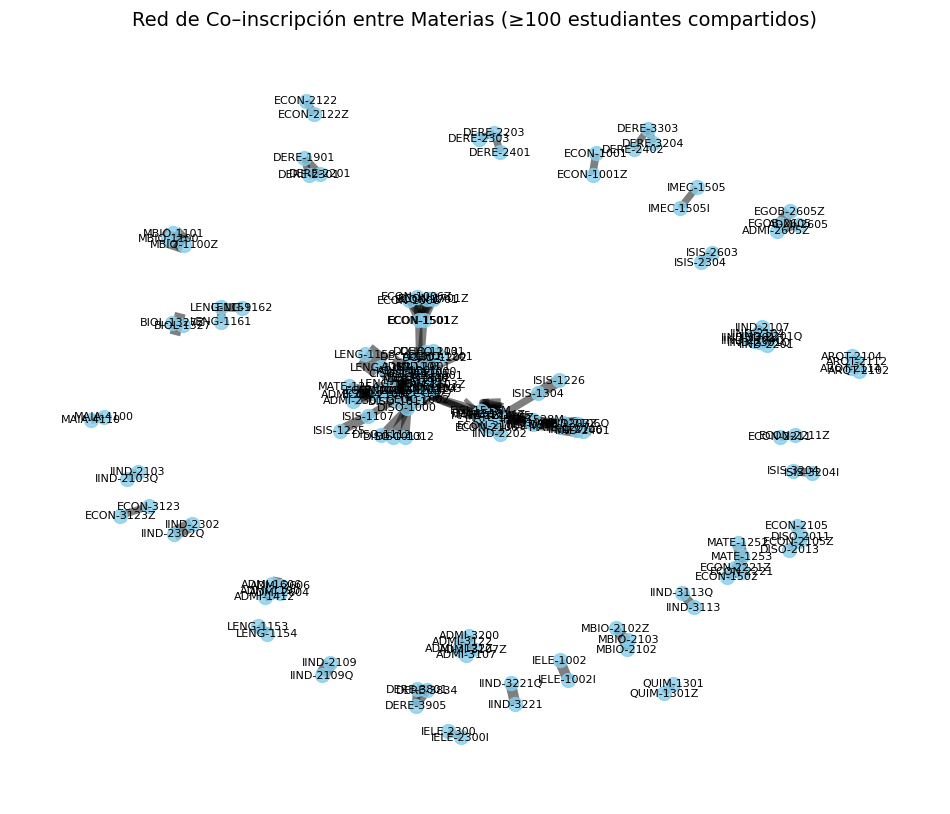

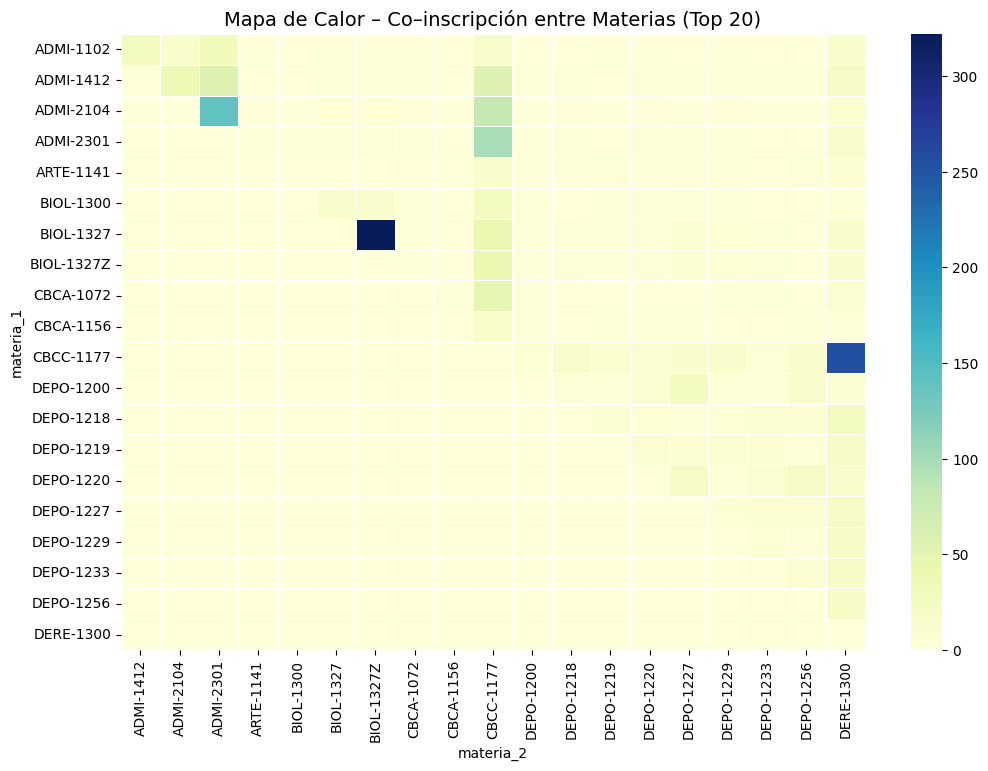

In [ ]:

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
CLEAN_PATH = "decrypted_clean.csv"
df = pd.read_csv(CLEAN_PATH)


# Filtrar pares con suficiente co–inscripción
threshold = 100
filtered_df = coinscripcion_df[coinscripcion_df["count"] >= threshold]

# Crear grafo
G = nx.Graph()
for _, row in filtered_df.iterrows():
    G.add_edge(row["materia_1"], row["materia_2"], weight=row["count"])

# Layout (posiciones de nodos)
pos = nx.spring_layout(G, k=0.5, seed=42)

plt.figure(figsize=(12, 10))
# Dibujar nodos
nx.draw_networkx_nodes(G, pos, node_size=100, node_color="skyblue", alpha=0.8)
# Dibujar aristas con grosor según número de co-inscripciones
nx.draw_networkx_edges(G, pos, width=[d["weight"] / 20 for (_, _, d) in G.edges(data=True)], alpha=0.5)
# Dibujar etiquetas
nx.draw_networkx_labels(G, pos, font_size=8, font_family="sans-serif")

plt.title("Red de Co–inscripción entre Materias (≥100 estudiantes compartidos)", fontsize=14)
plt.axis("off")
plt.show()


# 2. --- Mapa de calor (heatmap) de co–inscripción ---

# Crear matriz de co–inscripción (materia x materia)
pivot_df = coinscripcion_df.pivot(index="materia_1", columns="materia_2", values="count").fillna(0)

# Tomar solo las materias más comunes
top_materias = coinscripcion_df["materia_1"].value_counts().index[:20]
pivot_df = pivot_df.loc[pivot_df.index.isin(top_materias), pivot_df.columns.isin(top_materias)]

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, cmap="YlGnBu", linewidths=0.5)
plt.title("Mapa de Calor – Co–inscripción entre Materias (Top 20)", fontsize=14)
plt.show()
